# Model #2a – použití klasických metod počítačového vidění s pevnou mřížkou

Tento model slouží k automatickému rozpoznání, zda je Rubikova kostka složená, nebo ne – bez použití strojového učení nebo trénovacích dat. Místo toho spoléhá na přesné umístění kostky do předem dané mřížky, kde jsou analyzovány barevné oblasti.
> Poznámka: Neprovádí žádné odstranění pozadí ani detekci samotné kostky v obraze. Celý vstup musí být správně zarovnaný už při focení.

---

## Kalibrace barev
Na začátku probíhá kalibrace barev, kde uživatel umístí Rubikovu kostku tak, aby byla celá vidět v připravené mřížce (3×3). Program z každého obrázku získá barvu středu (medián oblasti středu). Tím se přiřadí šest konkrétních barev: bílá, žlutá, zelená, modrá, červená, oranžová.

<p align="left">
  <img src="https://github.com/MartinKilb/Rozpoznavani-Rubikovy-kostky/blob/main/vizualy/stickerless_kalibrace_white.png?raw=true" width="200"/>
  <img src="https://github.com/MartinKilb/Rozpoznavani-Rubikovy-kostky/blob/main/vizualy/stickerless_kalibrace_yellow.png?raw=true" width="200"/>
  <img src="https://github.com/MartinKilb/Rozpoznavani-Rubikovy-kostky/blob/main/vizualy/stickerless_kalibrace_green.png?raw=true" width="200"/>
  <img src="https://github.com/MartinKilb/Rozpoznavani-Rubikovy-kostky/blob/main/vizualy/stickerless_kalibrace_blue.png?raw=true" width="200"/>
  <img src="https://github.com/MartinKilb/Rozpoznavani-Rubikovy-kostky/blob/main/vizualy/stickerless_kalibrace_red.png?raw=true" width="200"/>
  <img src="https://github.com/MartinKilb/Rozpoznavani-Rubikovy-kostky/blob/main/vizualy/stickerless_kalibrace_orange.png?raw=true" width="200"/>
</p>

---

## Skenování jednotlivých stran
Poté uživatel postupně vyfotí všech 6 stran kostky. U každého snímku
musí být kostka opět správně zarovnána do mřížky,
získá se 9 samolepek dané strany. K focení se používá klasická webkamera.

---

## Vyhodnocení složenosti
Program zkontroluje, zda každá ze šesti stran obsahuje 9 samolepek stejné barvy. Pokud ano, je kostka považována za složenou. Model nekontroluje barvy vůči sobě, ani netvoří 3D reprezentaci celé kostky.

---

---

# Importy

In [1]:
from skimage.io import imread
from skimage.color import rgb2gray
from skimage.feature import canny
from skimage.transform import probabilistic_hough_line
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode, b64encode
from pathlib import Path
from PIL import Image

import io
import html
import time
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm

# JavaScriptové funkce

In [2]:
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      video.setAttribute('playsinline', '');
      video.style.position = 'relative';

      const canvas = document.createElement('canvas');
      canvas.style.position = 'absolute';
      canvas.style.top = '0';
      canvas.style.left = '0';

      const container = document.createElement('div');
      container.style.position = 'relative';
      container.appendChild(video);
      container.appendChild(canvas);

      div.appendChild(container);
      document.body.appendChild(div);

      const stream = await navigator.mediaDevices.getUserMedia({video: true});
      video.srcObject = stream;
      await video.play();

      // Synchronizace velikostí
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;

      const ctx = canvas.getContext('2d');

      // Kreslení mřížky v loopu
      function drawGrid() {
          ctx.clearRect(0, 0, canvas.width, canvas.height);
          ctx.strokeStyle = 'rgba(255, 0, 0, 0.9)';
          ctx.lineWidth = 2;

          const gridSize = 3; // 3x3 mřížka
          const totalBoxSize = 240; // Zabere 50 % šířky plátna
          const cellSize = totalBoxSize / gridSize;

          const startX = (canvas.width - totalBoxSize) / 2;
          const startY = (canvas.height - totalBoxSize) / 2;

          for (let row = 0; row < gridSize; row++) {
            for (let col = 0; col < gridSize; col++) {
              const x = startX + col * cellSize;
              const y = startY + row * cellSize;
              ctx.strokeRect(x, y, cellSize, cellSize);
            }
          }
      }

      drawGrid();

      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);
      await new Promise((resolve) => capture.onclick = resolve);

      const snapCanvas = document.createElement('canvas');
      const videoWidth = video.videoWidth;
      const videoHeight = video.videoHeight;
      const size = Math.min(videoWidth, videoHeight);
      const offsetX = (videoWidth - size) / 2;
      const offsetY = (videoHeight - size) / 2;
      snapCanvas.width = size;
      snapCanvas.height = size;

      const snapCtx = snapCanvas.getContext('2d');
      snapCtx.drawImage(video, offsetX, offsetY, size, size, 0, 0, size, size);

      stream.getVideoTracks()[0].stop();
      div.remove();

      return snapCanvas.toDataURL('image/jpeg', quality);
    }
  ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))

  # convert to OpenCV image
  img = np.asarray(js_to_image(data))

  # optional saving
  cv2.imwrite(filename, img)
  return img

# Funkce pro kalibraci kamery

In [3]:
def get_average_hsv(region, color):
    """Výpočet průměrné hodnoty HSV z této oblasti."""
    h = np.median(region[:, :, 0])
    s = np.median(region[:, :, 1])
    v = np.median(region[:, :, 2])

    return h, s, v

In [4]:
def get_region(image):
    """Získá oblast mřížky."""
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    height, width, _ = image.shape
    center_x, center_y = width // 2, height // 2
    region_size = 30
    half_size = region_size // 2

    region = hsv[center_y - half_size : center_y + half_size, center_x - half_size : center_x + half_size]
    return region

In [5]:
def show_calibrated_region(region):
    """Zobrazí kalibrovaný region."""
    plt.imshow(cv2.cvtColor(region, cv2.COLOR_HSV2RGB))
    plt.title("Oblast kalibrace")
    plt.axis('off')
    plt.show()

# Kalibrace kamery

In [20]:
def calibrate_camera():
    """Zkalibruje postupně všech 6 barev Rubikovy kostky."""

    average_hue_arr = {}
    average_saturation_arr = {}
    average_value_arr = {}

    for color in COLORS:
        while True:
            print(f"Probíhá kalibrace barvy {color}...")
            image = take_photo()
            region = get_region(image)
            show_calibrated_region(region)

            h, s, v = get_average_hsv(region, color)

            average_hue_arr[color] = h
            average_saturation_arr[color] = s
            average_value_arr[color] = v

            choice = input(f"Jsi spokojený? (a = ano, jakákoliv jiná klávesa = zopakovat fotku)").lower()
            if choice == 'a':
                break
            else:
                print(f"Opakuji kalibraci barvy {color}...")

    print(f"Kalibrace byla úspěšně dokončena.")

    return average_hue_arr, average_saturation_arr, average_value_arr

# Dílčí funkce

In [7]:
def get_grid_points(image, grid_size=3, box_fraction=0.5):
    """Získá body mezi hlavními body mřížky."""
    H, W = image.shape[:2]

    totalBoxSize = box_fraction * min(W, H)  # velikost čtverce
    startX = (W - totalBoxSize) / 2
    startY = (H - totalBoxSize) / 2

    step = totalBoxSize / grid_size  # vzdálenost mezi body

    points = []
    for i in range(grid_size + 1):
        row = []
        for j in range(grid_size + 1):
            x = startX + j * step
            y = startY + i * step
            row.append([x, y])
        points.append(row)

    return np.array(points)  # tvar (4,4,2)

In [8]:
def show_grid_points(grid_points):
    """Zobrazí všech 16 bodů mřížky na obrázku."""
    for row in grid_points:
        for (x, y) in row:
            cv2.circle(image, (int(x), int(y)), radius=5, color=(0, 0, 255), thickness=-1)

    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    plt.imshow(image_rgb)
    plt.axis('off')
    plt.show()

In [9]:
def average_color_in_quad(image, pts):
    """Vypočítá průměrnou barvu ve zvolené oblasti."""
    # Vytvoříme masku polygonu
    mask = np.zeros(image.shape[:2], dtype=np.uint8)
    cv2.fillPoly(mask, [pts.astype(np.int32)], 255)

    # Najdeme všechny pixely v masce
    masked_pixels = cv2.bitwise_and(image, image, mask=mask)

    # Spočítáme průměr přes všechny barevné kanály
    mean_color = []
    for i in range(3):  # kanály B,G,R
        channel_vals = masked_pixels[:, :, i][mask == 255]
        mean_val = np.median(channel_vals) if len(channel_vals) > 0 else 0
        mean_color.append(mean_val)

    return tuple(mean_color)

In [10]:
def get_colors_matrix(image):
    """Na základě získání průměrné barvy v každé oblasti spočítá celou matici barev (samolepek)."""
    colors_matrix = np.zeros((3, 3, 3))  # 3x3 políčka, 3 barvy (B, G, R)

    for i in range(3):
        for j in range(3):
            # 4 body daného políčka:
            quad = np.array([
                grid_points[i, j],
                grid_points[i, j+1],
                grid_points[i+1, j+1],
                grid_points[i+1, j]
            ])
            avg_col = average_color_in_quad(image, quad)
            colors_matrix[i, j] = avg_col
    return colors_matrix

In [11]:
def bgr_to_hsv_pixel(bgr):
    """Převádí barvu z bgr do hsv."""
    bgr_uint8 = np.uint8([[bgr]])  # musí být uint8, tvar (1,1,3)
    hsv = cv2.cvtColor(bgr_uint8, cv2.COLOR_BGR2HSV)
    return hsv[0, 0]  # vrací [H, S, V]

In [12]:
def find_closest_hsv_color(hsv_pixel, average_hue_arr, average_saturation_arr, average_value_arr, threshold=5):
    """Najde nejbližší barvu k dané barvě z matice v hsv prostoru. Vybírá z nakalibrovaných barev."""

    distances = []
    # Vypočítáme referenční hsv pro každou barvu.
    for color in average_hue_arr.keys():
        ref_h = average_hue_arr[color]
        ref_s = average_saturation_arr[color]
        ref_v = average_value_arr[color]
        dist = np.linalg.norm(np.array(hsv_pixel) - np.array([ref_h, ref_s, ref_v]))
        distances.append((dist, color))

    # Seřadíme podle vzdálenosti vzestupně
    distances.sort(key=lambda x: x[0])

    # Nejbližší a druhá nejbližší vzdálenost
    min_dist, closest_color = distances[0]
    if len(distances) > 1:
        second_dist, _ = distances[1]
    else:
        second_dist = float('inf')

    # Pokud je minimální vzdálenost větší než threshold,
    # nebo pokud je rozdíl mezi první a druhou vzdáleností malý (nejistota),
    # pak vrátíme "není možné určit".
    if (second_dist - min_dist) < threshold:
        return "není možné určit"
    else:
        return closest_color

In [13]:
def get_text_matrix(colors_matrix, average_hue_arr, average_saturation_arr, average_value_arr):
    """Z matice barev (bgr) získáme přímo jednotlivé barvy textově."""
    text_matrix = np.empty(colors_matrix.shape[:2], dtype=object)

    for i in range(colors_matrix.shape[0]):
        for j in range(colors_matrix.shape[1]):
            bgr_pixel = colors_matrix[i, j]
            hsv_pixel = bgr_to_hsv_pixel(bgr_pixel)
            # print(f"hsv_pixel: {hsv_pixel}")
            text_matrix[i, j] = find_closest_hsv_color(hsv_pixel, average_hue_arr, average_saturation_arr, average_value_arr)

    return text_matrix

In [14]:
def is_solved_side(matrix):
    """Vrátí True, pokud všechny prvky v 3x3 matici jsou stejné."""
    first = matrix[0][0]
    for row in matrix:
        for cell in row:
            if cell != first:
                return False
    return True

## Definice barev
> Poznámka: Většina Rubikových kostek má těchto 6 barev. [Western color scheme.](https://speedsolving.fandom.com/wiki/Western_Color_Scheme)

In [15]:
COLORS = ['white', 'yellow', 'green', 'blue', 'red', 'orange']

# Vyzkoušejte si model
Zde je možnost otestovat si náš model rovnou z vaší webkamery. \
Nejprve je potřeba nakalibrovat jednotlivé barvy, kalibrace probíhá z barvy samolepky, kterou umístíte doprostřed mřížky. Postupně tedy vyfotťe všech 6 barev. Po každém vyfocení se můžete rozhodnout, zda kalibraci potvrdíte (zmáčnutím klávesy a), nebo zopakujete (zmáčknutím jakékoliv jiné klávesy).

Probíhá kalibrace barvy white...


<IPython.core.display.Javascript object>

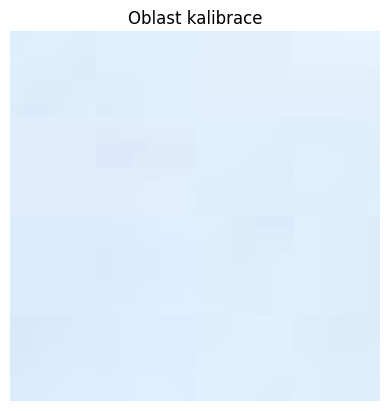

Jsi spokojený? (a = ano, jakákoliv jiná klávesa = zopakovat fotku)a
Probíhá kalibrace barvy yellow...


<IPython.core.display.Javascript object>

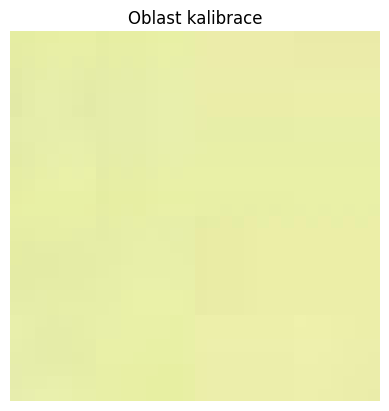

Jsi spokojený? (a = ano, jakákoliv jiná klávesa = zopakovat fotku)a
Probíhá kalibrace barvy green...


<IPython.core.display.Javascript object>

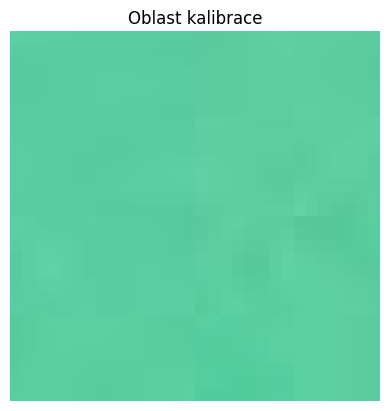

Jsi spokojený? (a = ano, jakákoliv jiná klávesa = zopakovat fotku)a
Probíhá kalibrace barvy blue...


<IPython.core.display.Javascript object>

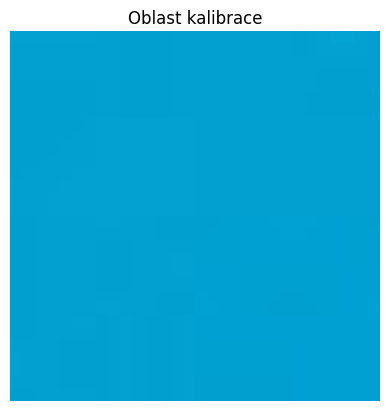

Jsi spokojený? (a = ano, jakákoliv jiná klávesa = zopakovat fotku)a
Probíhá kalibrace barvy red...


<IPython.core.display.Javascript object>

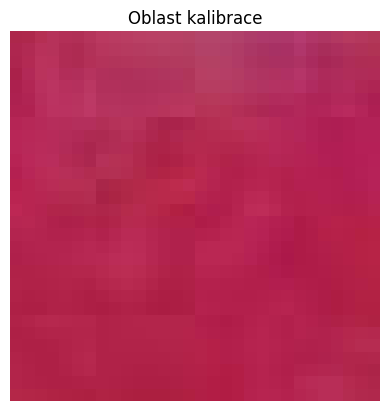

Jsi spokojený? (a = ano, jakákoliv jiná klávesa = zopakovat fotku)a
Probíhá kalibrace barvy orange...


<IPython.core.display.Javascript object>

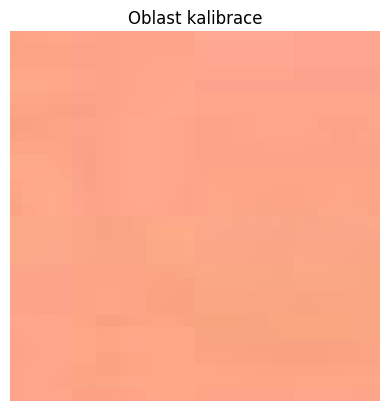

Jsi spokojený? (a = ano, jakákoliv jiná klávesa = zopakovat fotku)a
Kalibrace byla úspěšně dokončena.


In [28]:
# Kalibrace barev
average_hue_arr, average_saturation_arr, average_value_arr = calibrate_camera()

Vyfoťte postupně šest stran Rubikovy kostky.

<IPython.core.display.Javascript object>

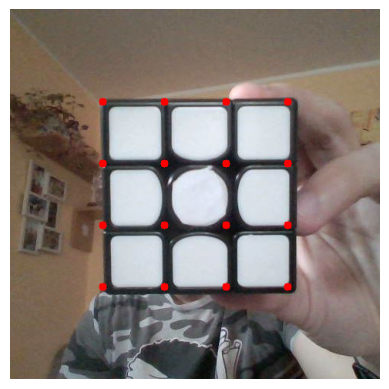

<IPython.core.display.Javascript object>

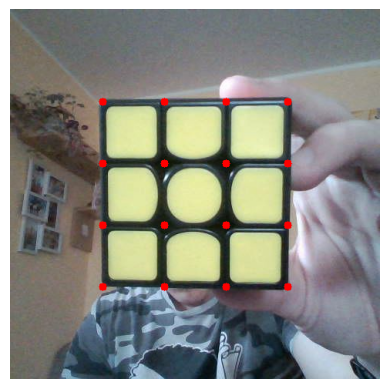

<IPython.core.display.Javascript object>

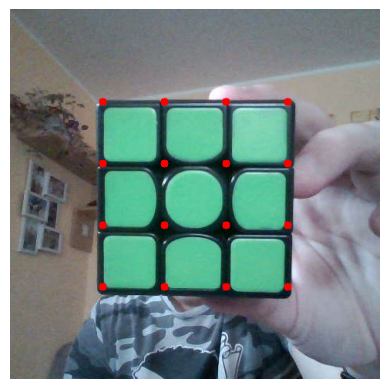

<IPython.core.display.Javascript object>

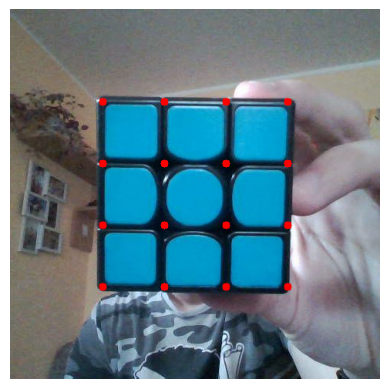

<IPython.core.display.Javascript object>

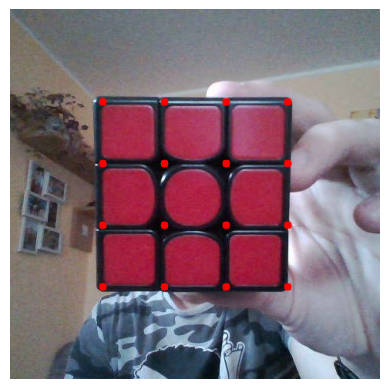

<IPython.core.display.Javascript object>

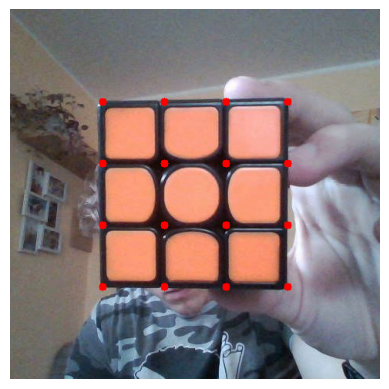

In [29]:
cube = []

for i in range(6):
    image = take_photo()

    # Získání klíčových bodů
    grid_points = get_grid_points(image)
    show_grid_points(grid_points)

    # Matice barev
    colors_matrix = get_colors_matrix(image)
    text_matrix = get_text_matrix(colors_matrix, average_hue_arr, average_saturation_arr, average_value_arr)

    cube.append(text_matrix)

# Kontrola celé kostky a její reprezentace
> Poznámka: Nutno podotknout, že pokud bychom chtěli reprezentaci převést do 3D, museli bychom se držet určitých konvencí při skenování.

In [30]:
# Kontrola, jestli je kostka složená
solved = all(is_solved_side(side) for side in cube)

if solved:
    print("🟩 Kostka je složená!\n")
else:
    print("🟥 Kostka není složená.\n")

# Reprezentace kostky
for i, side in enumerate(cube):
    print(f"Strana {i+1}:")
    for row in side:
        print(row)
    print()

🟩 Kostka je složená!

Strana 1:
['white' 'white' 'white']
['white' 'white' 'white']
['white' 'white' 'white']

Strana 2:
['yellow' 'yellow' 'yellow']
['yellow' 'yellow' 'yellow']
['yellow' 'yellow' 'yellow']

Strana 3:
['green' 'green' 'green']
['green' 'green' 'green']
['green' 'green' 'green']

Strana 4:
['blue' 'blue' 'blue']
['blue' 'blue' 'blue']
['blue' 'blue' 'blue']

Strana 5:
['red' 'red' 'red']
['red' 'red' 'red']
['red' 'red' 'red']

Strana 6:
['orange' 'orange' 'orange']
['orange' 'orange' 'orange']
['orange' 'orange' 'orange']



# Ukázkový příklad vyhodnocení na základě vstupů

## Složená kostka
<p align="left">
  <img src="https://github.com/MartinKilb/Rozpoznavani-Rubikovy-kostky/blob/main/vizualy/white.png?raw=true" width="200"/>
  <img src="https://github.com/MartinKilb/Rozpoznavani-Rubikovy-kostky/blob/main/vizualy/yellow.png?raw=true" width="200"/>
  <img src="https://github.com/MartinKilb/Rozpoznavani-Rubikovy-kostky/blob/main/vizualy/green.png?raw=true" width="200"/>
  <img src="https://github.com/MartinKilb/Rozpoznavani-Rubikovy-kostky/blob/main/vizualy/blue.png?raw=true" width="200"/>
  <img src="https://github.com/MartinKilb/Rozpoznavani-Rubikovy-kostky/blob/main/vizualy/red.png?raw=true" width="200"/>
  <img src="https://github.com/MartinKilb/Rozpoznavani-Rubikovy-kostky/blob/main/vizualy/orange.png?raw=true" width="200"/>
</p>


Strana 1:
['white' 'white' 'white']
['white' 'white' 'white']
['white' 'white' 'white']

Strana 2:
['yellow' 'yellow' 'yellow']
['yellow' 'yellow' 'yellow']
['yellow' 'yellow' 'yellow']

Strana 3:
['green' 'green' 'green']
['green' 'green' 'green']
['green' 'green' 'green']

Strana 4:
['blue' 'blue' 'blue']
['blue' 'blue' 'blue']
['blue' 'blue' 'blue']

Strana 5:
['red' 'red' 'red']
['red' 'red' 'red']
['red' 'red' 'red']

Strana 6:
['orange' 'orange' 'orange']
['orange' 'orange' 'orange']
['orange' 'orange' 'orange']


## Nesložená kostka
<p align="left">
  <img src="https://github.com/MartinKilb/Rozpoznavani-Rubikovy-kostky/blob/main/vizualy/unsolved_white.png?raw=true" width="200"/>
  <img src="https://github.com/MartinKilb/Rozpoznavani-Rubikovy-kostky/blob/main/vizualy/unsolved_yellow.png?raw=true" width="200"/>
  <img src="https://github.com/MartinKilb/Rozpoznavani-Rubikovy-kostky/blob/main/vizualy/unsolved_green.png?raw=true" width="200"/>
  <img src="https://github.com/MartinKilb/Rozpoznavani-Rubikovy-kostky/blob/main/vizualy/unsolved_blue.png?raw=true" width="200"/>
  <img src="https://github.com/MartinKilb/Rozpoznavani-Rubikovy-kostky/blob/main/vizualy/unsolved_red.png?raw=true" width="200"/>
  <img src="https://github.com/MartinKilb/Rozpoznavani-Rubikovy-kostky/blob/main/vizualy/unsolved_orange.png?raw=true" width="200"/>
</p>


🟥 Kostka není složená.

Strana 1:
['red' 'green' 'yellow']
['red' 'white' 'yellow']
['orange' 'orange' 'red']

Strana 2:
['red' 'green' 'orange']
['yellow' 'yellow' 'orange']
['green' 'yellow' 'orange']

Strana 3:
['blue' 'white' 'orange']
['white' 'green' 'red']
['yellow' 'yellow' 'yellow']

Strana 4:
['green' 'orange' 'white']
['white' 'blue' 'blue']
['blue' 'red' 'green']

Strana 5:
['blue' 'blue' 'white']
['red' 'red' 'white']
['blue' 'blue' 'white']

Strana 6:
['yellow' 'orange' 'green']
['green' 'orange' 'blue']
['red' 'green' 'white']